In [25]:
from hest import iter_hest, XeniumReader
from hest.HESTData import *
from hest import h5ad_reader
from hest.h5ad_reader import *
import dask
from pathlib import Path
import scanpy as sc

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import math

In [26]:
# ---- Base folder ----
base_root = Path("/project/simmons_hts/kxu/hest/xenium_data")

# Datasets to inspect
datasets = [f"XeniumPR{i}" for i in range(4, 6)]

# ---- Parameters ----
cols = 4         # number of columns in grid
max_show = None    # limit per dataset (set None for all)
thumb_size = (800, 800)  # resize to speed up plotting

for ds in datasets:
    ds_dir = base_root / ds
    if not ds_dir.exists():
        print(f"⚠️ {ds_dir} not found, skipping.")
        continue

    found = sorted(ds_dir.rglob("spatial_plots.png"))
    if not found:
        print(f"⚠️ No spatial_plots.png found in {ds_dir}")
        continue

    if max_show:
        found = found[:max_show]

    print(f"🧩 {ds}: visualising {len(found)} plots")

    # --- build grid ---
    rows = math.ceil(len(found) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for i, (ax, path) in enumerate(zip(axes, found)):
        try:
            img = Image.open(path)
            img.thumbnail(thumb_size)
            ax.imshow(img)
            rel = path.relative_to(ds_dir)
            ax.set_title(str(rel.parent), fontsize=8)
            ax.axis("off")
        except Exception as e:
            ax.axis("off")
            ax.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center", fontsize=8)

    # hide unused subplots
    for j in range(len(found), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    # --- save to PDF under dataset folder ---
    out_pdf = ds_dir / "spatial_plots.pdf"
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.close(fig)
    print(f"✔ Saved grid to {out_pdf}\n")

print("✅ Done generating all spatial_plots.pdf files.")


🧩 XeniumPR4: visualising 20 plots
✔ Saved grid to /project/simmons_hts/kxu/hest/xenium_data/XeniumPR4/spatial_plots.pdf

🧩 XeniumPR5: visualising 21 plots
✔ Saved grid to /project/simmons_hts/kxu/hest/xenium_data/XeniumPR5/spatial_plots.pdf

✅ Done generating all spatial_plots.pdf files.


# local edits: crop spots

In [3]:
# keep original function
_orig_calc_qc = sc.pp.calculate_qc_metrics

try:
    # replace with a no-op
    sc.pp.calculate_qc_metrics = lambda *args, **kwargs: None

finally:
    # restore original function
    sc.pp.calculate_qc_metrics = _orig_calc_qc

NameError: name 'out_dir' is not defined

## XeniumPR4S2ROI6

In [14]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumPR4/slide2/ROI6")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

        'pixel_size' is 0.2204892621273106
        'wsi' is <width=24638, height=26041, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 2016 / 2016


/tmp/ipykernel_2732130/2877911976.py:21: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


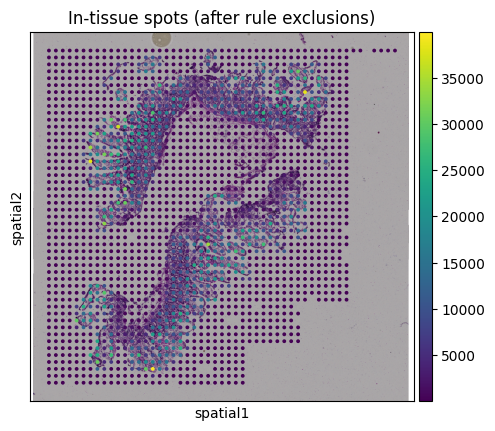

/tmp/ipykernel_2732130/2877911976.py:29: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",


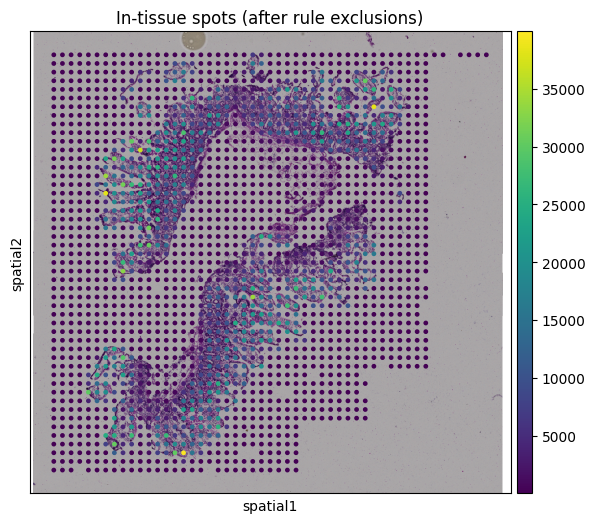

In [17]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'strip', 'side':'top', 'size':0.09, 'units':'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

# now plot (smaller image -> smaller fig)
fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",
                    color="total_counts", title="In-tissue spots (after rule exclusions)",
                    return_fig=True, show=False)
fig.set_size_inches(8,6)
fig.canvas.draw()
#display(fig)

In [18]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow
